### Library loading

In [1]:
from IPython.display import Markdown as md
from pathlib import Path
from shutil import unpack_archive
from pickle import dump, load
import numpy as np
import pandas as pd
from itertools import product
import matplotlib
matplotlib.rcParams['font.family'] = 'Segoe UI'
import matplotlib.pyplot as plt
%matplotlib inline
import functions as f
from kaggle import Kaggle

### Main settings

In [2]:
COMPETITION = 'skillbox-recommender-system'            # Competition name on Kaggle platform
PROJECT_PATH = Path('D:/skillbox-recommender-system')  # Project folder path
DATA_PATH = PROJECT_PATH / 'data'                      # Data folder path
TRANSACTIONS_PATH = DATA_PATH / 'transactions.csv'     # Path to transaction log file
PRODUCTS_PATH = DATA_PATH / 'products.csv'             # Path to product regisry file
EVAL_PATH = PROJECT_PATH / 'eval'                      # Path to evaluation file
WORKERS = 4                                            # Number of parallel computing processes

### Auxiliary functions

In [3]:
def multiprocessing(workers:int =WORKERS, data_path=DATA_PATH,
                    start: float = 0.0, stop: float = 1.0, num: int = 11,
                    func: str ='get_map10_by_rates', 
                    days_rate: float = 0.0, cart_rate: float = 0.0):
    '''
    Runs parallel computing processes script `multiproc.py`  with the required parameters.
    
    Arguments:
    workers - number of parallel processes
    data_path - data folder path
    func - performing function (см. multiproc.py)
    start, stop, num - start and end value of argument and value changing step
    days_rate - filtering rate by order day
    cart_rate - filtering rate by product add to cart order
    '''

    %run -t multiproc \
        --workers={workers} --data_path={data_path} \
        --start={start} --stop={stop} --num={num} \
        --func={func} --days_rate={days_rate} --cart_rate={cart_rate}
    
    with open(DATA_PATH / 'precisions.dmp', 'rb') as fp:
        map10 = load(fp)
    
    return map10

In [4]:
def load_data(file_name: str):
    '''
    Saves data dump to the local storage.
    '''
    file_path = DATA_PATH / file_name
    with open(file_path, 'rb') as fp:
        obj = load(fp)
    return obj

In [5]:
def save_data(obj, file_name: str):
    '''
    Loads data dump from the local storage.
    '''
    file_path = DATA_PATH / file_name
    with open(file_path, 'wb') as fp:
        dump(obj, fp)

### Data loading

In [6]:
kaggle = Kaggle(COMPETITION, verbose=1)

In [7]:
if not PROJECT_PATH.exists():
    PROJECT_PATH.mkdir()
    
if not DATA_PATH.exists():
    DATA_PATH.mkdir()

#### Transaction log

**Transaction log** contains the following fields:
- `order_id` - transaction unique identifier
- `user_id` - customer unique identifier
- `order_number` - customer's order number
- `order_dow` - day of week of order
- `order_hour_of_day` - hour of order
- `days_since_prior_order` - number of days since the previous order by the customer
- `product_id` - product identifier
- `add_to_cart_order` - the order under which the product was added to the cart
- `reordered` - whether the product was in previous order

Because we don’t know when (days after the last purchase) and at what time the customers will make their next orders, such information as the day of the week (field `order_dow`) and the time of making orders (`order_hour_of_day`) it doesn’t really help us. So it makes sense to exclude this information from the dataset. Also, it is unlikely information about the transaction identifier (`order_id`) and product reordering (`reordered`) can help to solve the task.

In [275]:
file_path = TRANSACTIONS_PATH.with_suffix('.dmp')
if not file_path.exists():
    if not TRANSACTIONS_PATH.with_suffix('.csv.zip').exists():
        kaggle.download_data_files([TRANSACTIONS_PATH.name], DATA_PATH)
    if TRANSACTIONS_PATH.with_suffix('.csv.zip').exists():
        unpack_archive(TRANSACTIONS_PATH.with_suffix('.csv.zip'), DATA_PATH)
        transactions = pd.read_csv(TRANSACTIONS_PATH, usecols=['user_id', 'order_number', 'days_since_prior_order', 
                                                               'product_id', 'add_to_cart_order'])
        
        with open(file_path, 'wb') as fp:
            dump(transactions, fp)
else:
    with open(file_path, 'rb') as fp:
        transactions = load(fp)

In [279]:
transactions['product_id'].nunique()

49465

In [280]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26408073 entries, 0 to 26408072
Data columns (total 5 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   user_id                 int64  
 1   order_number            int64  
 2   days_since_prior_order  float64
 3   product_id              int64  
 4   add_to_cart_order       float64
dtypes: float64(2), int64(3)
memory usage: 1007.4 MB


#### Product registry

**Product registry** contains fields:
- `product_id` - product unique identifier
- `product_name` - product name
- `aisle_id` - aisle unique identifier
- `department_id` - department unique identifier
- `aisle` - aisle name
- `department` - department name

In [267]:
file_path = PRODUCTS_PATH.with_suffix('.dmp')
if not file_path.exists():
    if not PRODUCTS_PATH.with_suffix('.csv.zip').exists():
        kaggle.download_data_files([PRODUCTS_PATH.name], DATA_PATH)
    if PRODUCTS_PATH.with_suffix('.csv.zip').exists():
        unpack_archive(PRODUCTS_PATH.with_suffix('.csv.zip'), DATA_PATH)
    products = pd.read_csv(PRODUCTS_PATH)
    with open(file_path, 'wb') as fp:
        dump(products, fp)
else:
    with open(file_path, 'rb') as fp:
        products = load(fp)    

### Model development hypothesis

The store sells food. An important feature of food sales is that people tend to buy about the same products. Of course, sometimes customers' preferences change, they try new products. But changes in product preferences occur systematically. I.e. the basic set of products is quite stable. Of course, in the lives of people periodically occur various events (birthdays, visitors, travel, etc.), which affect the grocery pack they buy. But for most people, these events don’t happen very often. So suppose that by detecting the set of products that the customer has most often ordered, especially recently, we can understand what products should be offered to him to buy.

Attention should also be paid to the order in which products are added to the basket. This feature may indirectly indicate the importance of a product to the customer. We usually put the most important products in the basket first.

### Data preprocessing

According to the proposed hypnosis to predict purchases you need to take into account the history of purchases of products. This requires a time stamp of shopping. However, in the original dataset there is only information about the number of days between purchases ([`days_since_prior_oder`). Therefore, we cannot retriev an absolute time scale of orders, but only a relative one. Because, according to the concept, it is important to know how long ago the other purchases were made relative to the planned, then the timeline should be counted from the last known purchase. To do this, add a feature to the transaction log, which will show the number of days from each purchase of the customer to his last purchase ([`days_before_last_order`). And further by ***order time*** we mean just ***value of this feature**.

Additionally, we will consider orders made on the same day as one order. We will combine the products present in them, and make the order of adding to the cart continuous. We will assume that the customer first added orders from the first order to the cart, then from the second, etc.

After processing, the **transaction log** will have the following fields:
- `user_id` - unique buyer identifier
- `days_before_last_order` - number of days since the previous transaction was made by this customer
- `product_id` - unique product identifier
- `add_to_cart_order` - number under which this product was added to the cart

We will train the model on all customer transactions except the latest ones. And we will check the quality of its work on the latest transactions. Therefore, we will immediately divide the transaction log into two parts:
- the latest transactions, on which we will evaluate the quality of predictions (`last_transactions`)
- previous transactions, on the basis of which we will form the model's predictions (`prior_transactions`).

In addition, to evaluate the accuracy of the model's predictions during validation, a list of products in the latest purchases (`last_products`) will be required.

In [10]:
file_paths = [DATA_PATH / file_name 
              for file_name in ['prior_transactions.dmp', 'last_transactions.dmp', 'last_products.dmp']]
if any(not file_path.exists() for file_path in file_paths):
    prior_transactions, last_transactions, last_products = f.preprocess_transactions(transactions)
    del transactions
    save_data(prior_transactions, 'prior_transactions.dmp')
    save_data(last_transactions, 'last_transactions.dmp')
    save_data(last_products, 'last_products.dmp')
else:
    prior_transactions = load_data('prior_transactions.dmp')
    last_transactions = load_data('last_transactions.dmp')
    last_products = load_data('last_products.dmp')

### Statistical analysis of data

To confirm the hypothesis, we will perform a statistical analysis of the data. First, we will find out what part of the products from the customers' last order were purchased by them earlier.

To do this, for each product of the last order of each customer, we find the orders of this customer in which it was previously encountered.

In [11]:
products_reordering = prior_transactions\
    .merge(last_transactions[['user_id', 'product_id']], on=['user_id', 'product_id'], how='right')
products_reordering['days_before_last_order'] += products_reordering['days_before_last_order_shift']

In [12]:
prior_ordered_fraction = products_reordering['days_before_last_order'].count() / products_reordering['days_before_last_order'].shape[0] * 100

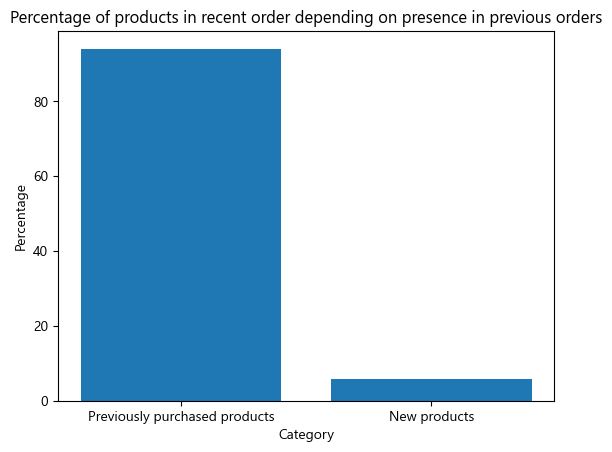

In [13]:
plot_data = pd.DataFrame()
plot_data['x'] = pd.Categorical(['Previously purchased products', 'New products'])
plot_data['y'] = [prior_ordered_fraction, 100 - prior_ordered_fraction]
fig, ax = plt.subplots()
_ = ax.bar(x=plot_data['x'], height=plot_data['y'])
ax.set_title('Percentage of products in recent order depending on presence in previous orders')
ax.set_xlabel('Category')
_ = ax.set_ylabel('Percentage')

# Saving data
save_data(plot_data, 'plot_reordering_prop_data.dmp')

Then, for each customer, we find the percentage of products from the last order that he or she has already purchased before, and display the distribution of this value using a histogram.

In [57]:
products_reordering_percentages = products_reordering.groupby('user_id')\
    .count().rename(columns={'product_id': 'products_total', 'days_before_last_order': 'reordered_products'})
products_reordering_percentages['reordered_percentage'] = \
    products_reordering_percentages['reordered_products'] / products_reordering_percentages['products_total'] * 100

In [61]:
plot_data = products_reordering_percentages['reordered_percentage'].value_counts(bins=20).reset_index(name='number_of_customers')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['reordered_percentage'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)
plot_data.dtypes

range                   interval[float64, right]
number_of_customers                        int64
reordered_percentage                     float64
dtype: object

In [62]:
# Saving data
save_data(plot_data, 'plot_reordering_percentages_data.dmp')

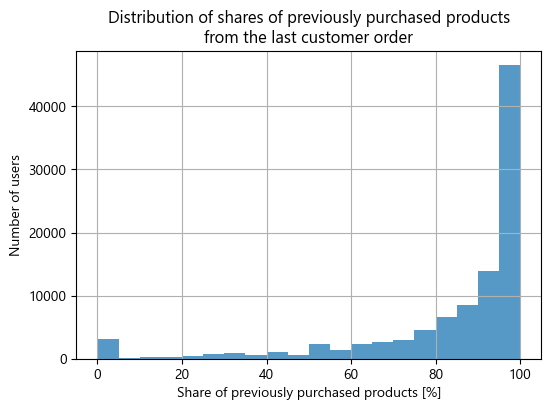

In [15]:
ax = products_reordering_percentages['reordered_percentage'].plot(
    kind='hist', bins=20,
    title='Distribution of customers by percentage of previously purchased products\nin recent order',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_xlabel('Percentage of previously purchased products')
_ = ax.set_ylabel('Number of customers')

The histogram clearly shows that the vast majority of products in the customers' latest order had already been ordered by them before. That is, the assumption that customers mostly buy products that they have bought before has been confirmed.

Now let's test the assumption that customers' product preferences may change over time, and that this factor should be taken into account. To do this, let's plot a graph of the share of products in customers' orders that are present in their latest orders, depending on the order time, with an interval of 1 month.

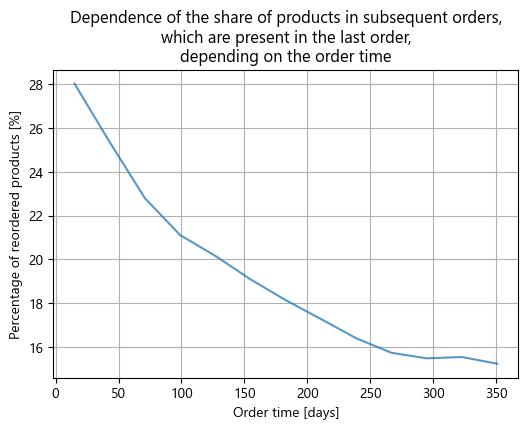

In [63]:
fig, ax = plt.subplots(figsize=(6, 4))
x = prior_transactions['days_before_last_order'] + prior_transactions['days_before_last_order_shift']
nbins = int(np.ceil((x.max() - x.min()) / 30))
total_counts, bins, _ = ax.hist(x, bins=nbins)
ax.clear()
x = products_reordering['days_before_last_order']
reordered_counts, _, _ = ax.hist(x, bins=nbins)
ax.clear()
x = [(x1 + x2) / 2 for x1, x2 in zip(bins[:-1], bins[1:])]
y = [reordered_count / total_count * 100 for total_count, reordered_count in zip(total_counts, reordered_counts)]
line, = ax.plot(x, y)
line.set_alpha(0.75)
ax.set_title('Dependence of the share of products in subsequent orders,\n'
             'which are present in the last order,\n'
             'depending on the order time')
ax.set_xlabel('Order time [days]')
ax.set_ylabel('Percentage of reordered products [%]')
ax.grid()

In [64]:

# Saving data
plot_data = pd.DataFrame()
plot_data['range'] = [pd.Interval(x1, x2, closed='right') for x1, x2 in zip(bins[:-1], bins[1:])] 
plot_data['order_time'] = x
plot_data['reordered_percentage'] = y
plot_data

,range,order_time,reordered_percentage
0,"(1.0, 29.0]",15.0,28.018811
1,"(29.0, 57.0]",43.0,25.347300
2,"(57.0, 85.0]",71.0,22.788222
3,"(85.0, 113.0]",99.0,21.106851
4,"(113.0, 141.0]",127.0,20.158093
5,"(141.0, 169.0]",155.0,19.083549
6,"(169.0, 197.0]",183.0,18.134068
7,"(197.0, 225.0]",211.0,17.272772
8,"(225.0, 253.0]",239.0,16.398058
9,"(253.0, 281.0]",267.0,15.733937


In [65]:
save_data(plot_data, 'plot_days_reordering_data.dmp')

The graph clearly **shows** that there is indeed a tendency for **customer preferences to change over time**. Thus, the share of products that were ordered **month** before the last order and are present in the last order is **28%**. But the share of presence in the last order of products purchased almost **year** ago is almost two times less - about **15%**.

Next, we will test another assumption that the order number of adding a product to the cart reflects its importance to the customer, and that this feature can be used to form predictions. To do this, we will plot a graph of the share of products in customer orders that are present in their last order, depending on the order number of products in the cart.

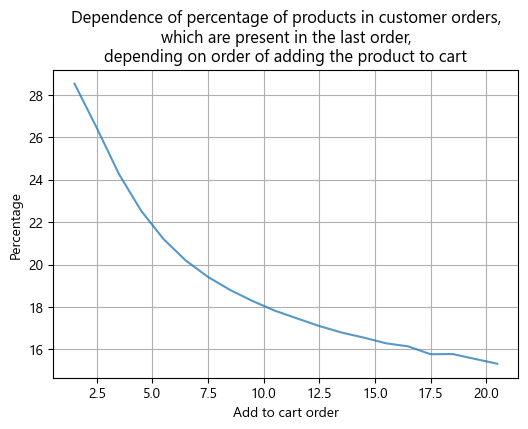

In [66]:
fig, ax = plt.subplots(figsize=(6, 4))
x = prior_transactions['add_to_cart_order']
nbins = int(x.max() - x.min())
total_density, bins, _ = ax.hist(x, bins=nbins, density=True)
add_to_cart_max = sum(total_density >= 0.01)
bins = bins[:add_to_cart_max + 1]
ax.clear()
total_counts, _, _ = ax.hist(x, bins=nbins)
total_counts = total_counts[:add_to_cart_max]
ax.clear()
x = products_reordering['add_to_cart_order']
reordered_counts, _, _ = ax.hist(x, bins=nbins)
reordered_counts = reordered_counts[:add_to_cart_max]
ax.clear()
x = [(x1 + x2) / 2 for x1, x2 in zip(bins[:-1], bins[1:])]
y = [reordered_count / total_count * 100 for total_count, reordered_count in zip(total_counts, reordered_counts)]
line, = ax.plot(x, y)
line.set_alpha(0.75)
ax.set_title('Dependence of percentage of products in customer orders,\n'
             'which are present in the last order,\n'
             'depending on order of adding the product to cart')
ax.set_xlabel('Add to cart order')
ax.set_ylabel('Percentage')
ax.grid()

In [67]:
# Saving data
plot_data = pd.DataFrame()
plot_data['range'] = [pd.Interval(x1, x2, closed='right') for x1, x2 in zip(bins[:-1], bins[1:])] 
plot_data['add_to_cart_order'] = x
plot_data['reordered_percentage'] = y
plot_data

,range,add_to_cart_order,reordered_percentage
0,"(1.0, 2.0]",1.5,28.521228
1,"(2.0, 3.0]",2.5,26.436565
2,"(3.0, 4.0]",3.5,24.255591
3,"(4.0, 5.0]",4.5,22.523740
4,"(5.0, 6.0]",5.5,21.199966
5,"(6.0, 7.0]",6.5,20.188015
6,"(7.0, 8.0]",7.5,19.413332
7,"(8.0, 9.0]",8.5,18.798299
8,"(9.0, 10.0]",9.5,18.281485
9,"(10.0, 11.0]",10.5,17.826473


In [68]:
save_data(plot_data, 'plot_cart_reordering_data.dmp')

The graph clearly shows that products from the last order were often among the first to be added to the cart in previous orders. Thus, the share of products that were **added to the cart first** and are present in the last order is about **28.5%**. But the share of products present in the last order and added to the cart **21** is almost two times less - about **15.5%**. So **this feature** should be used while model building.

### Creating a recommendation model

#### Filtering by frequency of product purchases

In accordance with the chosen concept of the prediction model, the rating of products for each customer should be primarily assessed by the frequency of purchases by this customer. In this case, products that the customer has never purchased will have a zero rating. And for products that the customer has purchased, the rating will be equal to the number of purchases of this product. This type of filtering can be described by the following formula:
$$r_{u,i}=\sum_{t \in T_u}s_{u,i,t},$$
where&nbsp;$r_{u,i}$ is the rating of product with number $i$ for customer with number $u$ ($i \in I$, where $I$ is the set of product numbers; $u \in U$, where $U$ is the set of customer numbers);  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$T_u$ - transaction numbers made by customer with number $u$ ($T_u \in T$, where $T$ is a set of transaction numbers);  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{u,i,t}$ - presence of product with number $i$ in transaction with number $t$ of customer with number $u$: $0$-no, $1$-yes.

Let's see what accuracy, according to the $MAP@10$ metric, the predictions based on such an algorithm have.

In [92]:
frequency_weights = f.get_weights(prior_transactions)
frequency_ratings = f.get_ratings(frequency_weights)
frequency_prediction = f.get_prediction(frequency_ratings)
frequency_map_10 = f.get_prediction_precision(true=last_products, prediction=frequency_prediction)

In [93]:
# Saving data
save_data(frequency_map_10, 'frequency_map_10.dmp')

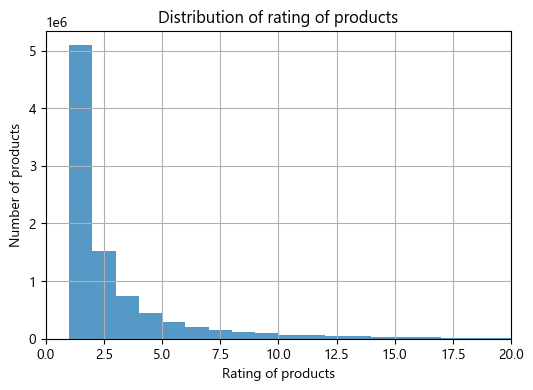

In [94]:
ax = frequency_ratings['rating'].plot(
    kind='hist',
    bins=frequency_ratings['rating'].max() - 1,
    title='Distribution of previously purchased products by rating',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75
)
ax.set_xlim(0, 20)
ax.set_xlabel('Rating of products')
_ = ax.set_ylabel('Number of products')

In [96]:
plot_data = frequency_ratings['rating'].value_counts(bins=frequency_ratings['rating'].max() - 1).reset_index(name='number_of_products')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['rating'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)
plot_data.dtypes

range                 interval[float64, right]
number_of_products                       int64
rating                                 float64
dtype: object

In [98]:
save_data(plot_data, 'plot_ratings_hist_data.dmp')

In [99]:
md(
    f'The value of the $MAP@10$ metric in this case is **{frequency_map_10:.6f}**. '
    f'This is already an acceptable result. We will try to improve it with additional filtering.'
)

The value of the $MAP@10$ metric in this case is **0.280609**. This is already an acceptable result. We will try to improve it with additional filtering.

#### Filter by purchase time

As a result of the exploratory analysis, we confirmed the existence of a dependence of the share of purchased products included in the next order on the time of the order. In this regard, the importance of orders should be reduced as they move away in time from the last order. To do this, we will introduce the concept of "**weight**" of a transaction, which will depend on the time of its execution. Judging by the appearance of the graph of the above dependence, it can be assumed that it is exponential in nature. Therefore, we will reduce the transaction weights exponentially, i.e. we will apply the so-called exponential filtering, in which the transaction weights are determined by the formula:
$$w_{u,t}=e^{-d_{u,t}·a_d},$$
where&nbsp;$w_{u,t}$ is the weight of the transaction with the number $t$ of the customer with the number $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$d_{u,t}$ - time of transaction with number $t$ of customer with number $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_d$ - filtration rate (positive number).

In this case, the formula for calculating product ratings will take the following form:
$$r_{u,i}=\sum_{t \in T_u}s_{u,i,t}·w_{u,t}=\sum_{t \in T_u}s_{u,i,t}·e^{-d_{u,t}·a_d}.$$

To check the effect of filtering by purchase time and the influence of the value of the rate $a_d$ on the accuracy of predictions using it, we will plot a graph of the dependence of the value of the metric $MAP@10$ on the value of this rate.

In [100]:
start, stop, num = 0.0, 0.1, 21
map10_days = multiprocessing(start=start, stop=stop, num=num, func='get_map10_by_days_rates')


IPython CPU timings (estimated):
  User   :       0.06 s.
  System :       0.00 s.
Wall time:     126.67 s.


<Figure size 640x480 with 0 Axes>

In [156]:
map10_days_approximated, days_rate = f.approximate_precision_by_rate(map10_days.index, map10_days, 7)
days_weights = f.get_weights(prior_transactions, days_rate=days_rate)
days_ratings = f.get_ratings(days_weights)
days_prediction = f.get_prediction(days_ratings)
days_map10 = f.get_prediction_precision(last_products, days_prediction)

In [159]:
# Saving data
save_data(days_map10, 'days_map10.dmp')
save_data(days_rate, 'days_rate.dmp')

In [157]:
plot_data = map10_days.reset_index()
plot_data['type'] = 'actual'
index = pd.RangeIndex(map10_days.shape[0], map10_days.shape[0] + map10_days_approximated.shape[0])
for i in index:
    plot_data.loc[i, 'type'] = 'approximated'
plot_data.loc[index, 'days_rate'] = map10_days.index
plot_data.loc[index, 'precision'] = map10_days_approximated
# plot_data.loc[index.stop] = [days_rate, days_map10, 'peak']
plot_data

,days_rate,precision,type
0,0.000,0.280609,actual
1,0.005,0.306499,actual
2,0.010,0.320170,actual
3,0.015,0.324974,actual
4,0.020,0.325016,actual
5,0.025,0.322810,actual
6,0.030,0.319978,actual
7,0.035,0.316991,actual
8,0.040,0.314118,actual
9,0.045,0.311495,actual


In [158]:
save_data(plot_data, 'plot_days_data.dmp')

(0.0, 20.0)

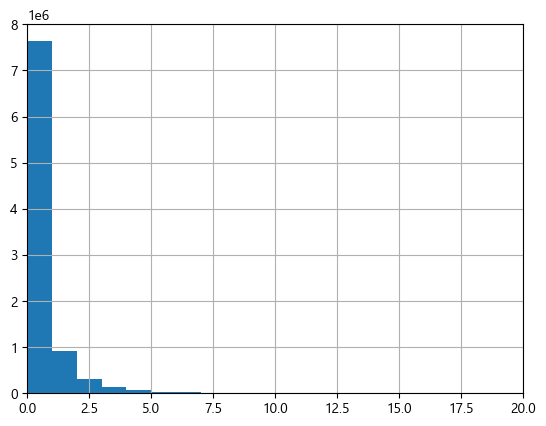

In [23]:
ax = days_ratings['rating'].hist(bins=int(np.ceil(days_ratings['rating']).max()))
ax.set_xlim(0, 20)

In [178]:
bins = [
    pd.Interval(left=left, right=left+1) 
    for left in range(int(np.floor(days_ratings['rating'].min())), int(np.ceil(days_ratings['rating'].max())))  
]
plot_data = days_ratings['rating'].value_counts(bins=bins).reset_index(name='number_of_products')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['rating'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)

,range,number_of_products,rating
0,"(0, 1]",7632757,0.5
1,"(1, 2]",914752,1.5
2,"(2, 3]",311602,2.5
3,"(3, 4]",132340,3.5
4,"(4, 5]",65266,4.5
5,"(5, 6]",34554,5.5
6,"(6, 7]",18712,6.5
7,"(7, 8]",9801,7.5
8,"(8, 9]",4794,8.5
9,"(9, 10]",2650,9.5


In [179]:
save_data(plot_data, 'plot_days_hist_data.dmp')

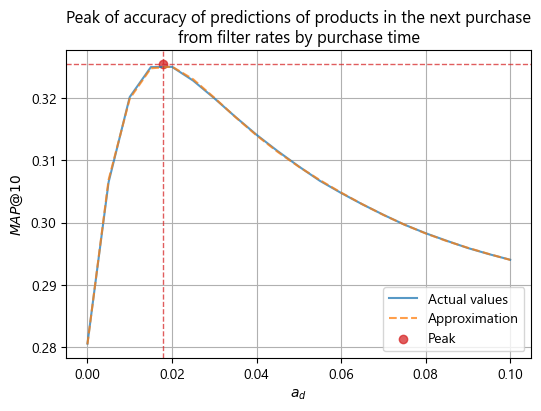

In [180]:
ax = map10_days.plot(
    title='Peak of accuracy of predictions of products in the next purchase'
    '\nfrom filter rates by purchase time',
    xlabel='$a_d$', ylabel='$MAP@10$',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.plot(map10_days.index.values, map10_days_approximated, linestyle='--', color='#ff7f0e', alpha=0.75)
ax.scatter(days_rate, days_map10, color='#d62728', linewidth=1, alpha=0.75)
ax.axvline(days_rate, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
ax.axhline(days_map10, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
_ = ax.legend(['Actual values', 'Approximation', 'Peak'])

The graph shows that the value of the $a_d$ rate significantly affects the quality of filtration. At **values** of this rate **close to zero** (i.e. at weak filtration), as it should be, **the value of the $MAP@10$ metric is close to the value** obtained only on the basis of **purchase frequency**. Then, **as the rate grows**, a **rapid growth** of the prediction quality is observed, which **reaches** its **peak** at a value of the $a_d$ rate **in the region of $0.015...0.02$**. As the **rate value continues to grow**, the quality of filtration** expectedly begins **slowly decreasing** to the original value (the $MAP@10$ metric returns to the value obtained only on the basis of purchase frequency).

Let's try to determine the position and magnitude of the peak of this dependence more precisely. To do this, we approximate the function on $[0, 0.1]$ of the $MAP@10(a_d)$ graph using a 7th-order polynomial function. After that, we find a point on this segment where the derivative of the polynomial function is zero. This will be the desired point of the refined position of the peak - the optimal value of the $a_d$ rate. And then, at that point, we will find the real value of the $MAP@10$ metric. This value will characterize the accuracy of predictions when using time filtering.

In [181]:
md(
    '**Results**:<br>'
    'Filtering by purchase time gives a **significant increase in the accuracy** of predictions '
    f'(the $MAP@10$ metric **increased** by **{(days_map10 - frequency_map_10):.6f}** from {frequency_map_10:.6f} to {days_map10:.6f}) '
    f'with the filter rate $a_d$ equal to **{days_rate:.6f}**.'
)

**Results**:<br>Filtering by purchase time gives a **significant increase in the accuracy** of predictions (the $MAP@10$ metric **increased** by **0.044813** from 0.280609 to 0.325421) with the filter rate $a_d$ equal to **0.017791**.

***Note***:
*Of course, it would have been possible to further improve the accuracy of predictions on training data by using time filtering for each customer separately and even for each product separately. But in this case, our model would have a very low generalization ability, i.e. the model would become heavily overfitted.*

#### Filter by product adding to cart order

Using statistical analysis, we confirmed the existence of a dependence of the share of purchased products included in the next order, the share of purchased products included in the next order, on the numbers of their addition to. Let's try to take this circumstance into account and reduce the weight of products with an increase in the order number of their addition to the basket. Just as in the case of filtering by purchase time, we will use exponential filtering. And we will also use a single rate for the products of all transactions of all customers. As a result, each product of each transaction of each customer **has its own weight**, which is described by the following formula:

$$w_{u,i,t} = e^{-d_{u,t} a_d} e^{-c_{u,i,t} a_c}$$

where&nbsp;$w_{u,i,t}$ is the weight of product with number $i$ in transaction with number $t$ of customer with number $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$d_{u,t}$ - time of transaction with number $t$ of customer with number $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_d$ - filtering rate by transaction purchase time;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$c_{u,i,t}$ - order number of adding product with number $i$ to cart in transaction with number $t$ of customer with number $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_c$ - filtering rate by the number of adding a product to the basket.

When adding this filtering, the formula for calculating ratings will take the following form:
$$r_{u,i}=\sum_{t \in T_u}s_{u,i,t}·w_{u,i,t} = \sum_{t \in T_u}s_{u,i,t}·e^{-d_{u,t}·a_d}·e^{-c_{u,i,t}·a_c}$$

To check the effect of filtering by the adding to the cart order and the influence of the value of the rate $a_c$ on the accuracy of predictions using it, we will plot a graph of the dependence of the value of the metric $MAP@10$ on the value of this rate.

In [182]:
start, stop, num = 0.0, 0.05, 21
map10_cart = multiprocessing(start=start, stop=stop, num=num, func='get_map10_by_cart_rates', 
                             days_rate=days_rate)


IPython CPU timings (estimated):
  User   :       0.08 s.
  System :       0.00 s.
Wall time:     177.72 s.


<Figure size 640x480 with 0 Axes>

In [186]:
map10_cart_approximated, cart_rate = f.approximate_precision_by_rate(map10_cart.index, map10_cart, 3)
cart_weights = f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate)
cart_ratings = f.get_ratings(cart_weights)
cart_prediction = f.get_prediction(cart_ratings)
cart_map10 = f.get_prediction_precision(last_products, cart_prediction)

In [184]:
# Saving data
save_data(cart_map10, 'cart_map10.dmp')
save_data(cart_rate, 'cart_rate.dmp')

In [187]:
plot_data = map10_cart.reset_index()
plot_data['type'] = 'actual'
index = pd.RangeIndex(map10_cart.shape[0], map10_cart.shape[0] + map10_cart_approximated.shape[0])
for i in index:
    plot_data.loc[i, 'type'] = 'approximated'
plot_data.loc[index, 'cart_rate'] = map10_cart.index
plot_data.loc[index, 'precision'] = map10_cart_approximated
# plot_data.loc[index.stop] = [days_rate, days_map10, 'peak']
plot_data

,cart_rate,precision,type
0,0.0000,0.325421,actual
1,0.0025,0.326044,actual
2,0.0050,0.326223,actual
3,0.0075,0.326337,actual
4,0.0100,0.326420,actual
5,0.0125,0.326445,actual
6,0.0150,0.326482,actual
7,0.0175,0.326494,actual
8,0.0200,0.326456,actual
9,0.0225,0.326455,actual


In [188]:
save_data(plot_data, 'plot_cart_data.dmp')

In [189]:
bins = [
    pd.Interval(left=left, right=left+1) 
    for left in range(int(np.floor(cart_ratings['rating'].min())), int(np.ceil(cart_ratings['rating'].max())))  
]
plot_data = cart_ratings['rating'].value_counts(bins=bins).reset_index(name='number_of_products')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['rating'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)
plot_data

,range,number_of_products,rating
0,"(0, 1]",7875980,0.5
1,"(1, 2]",798549,1.5
2,"(2, 3]",250877,2.5
3,"(3, 4]",103451,3.5
4,"(4, 5]",50113,4.5
5,"(5, 6]",25420,5.5
6,"(6, 7]",13229,6.5
7,"(7, 8]",6197,7.5
8,"(8, 9]",3244,8.5
9,"(9, 10]",1863,9.5


In [190]:
save_data(plot_data, 'plot_cart_hist_data.dmp')

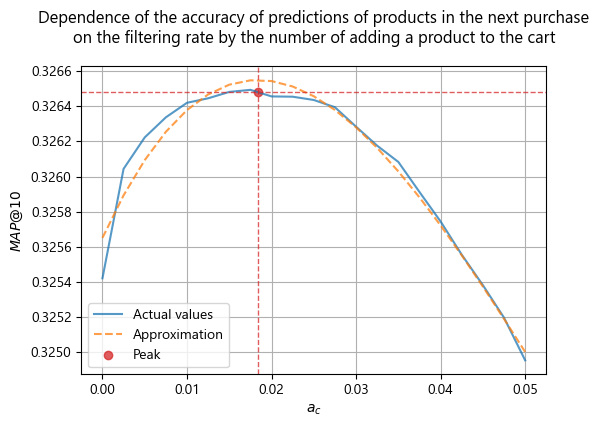

In [191]:
ax = map10_cart.plot(
    xlabel='$a_с$', ylabel='$MAP@10$',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_title('Dependence of the accuracy of predictions of products in the next purchase\n'
    'on the filtering rate by the number of adding a product to the cart', y=1.05)
ax.plot(map10_cart.index.values, map10_cart_approximated, linestyle='--', color='#ff7f0e', alpha=0.75)
ax.scatter(cart_rate, cart_map10, color='#d62728', linewidth=1, alpha=0.75)
ax.axvline(cart_rate, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
ax.axhline(cart_map10, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
_ = ax.legend(['Actual values', 'Approximation', 'Peak'])

(0.0, 20.0)

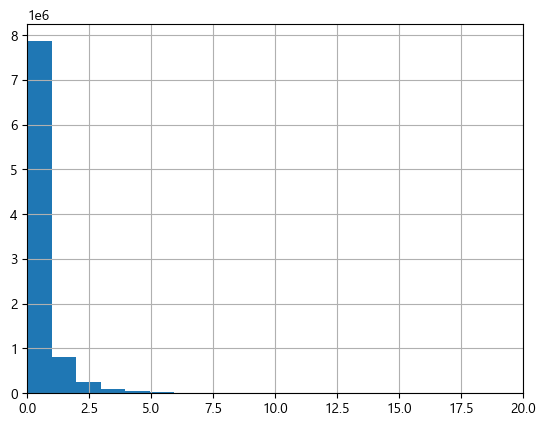

In [192]:
ax = cart_ratings['rating'].hist(bins=int(np.ceil(cart_ratings['rating']).max()))
ax.set_xlim(0, 20)

The graph shows that the value of the rate $a_c$ affects the quality of filtration. Thus, at **values** of this rate **close to zero** (i.e. at weak filtration), as it should be, **the value** of the $MAP@10$ metric **is close to the value obtained after applying frequency and time filtration**. Then, as the rates grow, a slight increase in the quality of filtration is observed, which **reaches** its **peak** at a rate value in the region of **0.016...0.02**. As the value of the rate continues to grow, the quality of filtration begins to rapidly decrease. And at rate values **greater than 0.045**, the effect of filtration becomes **negative** (the $MAP@10$ metric falls below the value obtained by filtering by frequency and time).

Let's try to determine the position and value of the peak of this dependence more precisely. To do this, on the segment $[0, 0.05]$ we approximate the function $MAP@10(a_d)$ using a 3rd order polynomial function. After that, we find a point on this segment at which the derivative of the polynomial function is zero. This will be the desired point of the refined position of the peak - the optimal value of the rate $a_c$. And then at that point we will find the real value of the metric $MAP@10$. This value will characterize the accuracy of predictions when using filtering by the number of adding a product to the basket.

In [193]:
md(
    '**Results**:<br>'
    'Filtering by the product addition number to the cart gave a **small increase in the accuracy** of predictions '
    f'(the $MAP@10$ metric **increased** by only **{(cart_map10 - days_map10):.6f}** from {days_map10:.6f} to {cart_map10:.6f}) '
    f'with the filtering rate $a_c$ equal to **{cart_rate:.6f}**.'
)

**Results**:<br>Filtering by the product addition number to the cart gave a **small increase in the accuracy** of predictions (the $MAP@10$ metric **increased** by only **0.001062** from 0.325421 to 0.326484) with the filtering rate $a_c$ equal to **0.018372**.

#### Filter by product popularity among all customers

For each product, in addition to the rating for a specific customer, you can determine its global rating, which is the average rating of this product among all customers. This rating is calculated using the formula:
$$r^g_i={\sum_{u \in U}r_{u,i} \over |U|},$$
where&nbsp;$r^g_i$ is the global rating of product with number $i$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$U$ is the set of customer numbers in transactions;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_{u,i}$ is the rating of product with number $i$ for customer with number $u$.

Let's try to analyze products with which global rating were mistakenly not included in the recommendations based on the above filters.

First, we find global product ratings based on previous transactions.

In [194]:
total_ratings = f.get_total_ratings(
    f.get_weights(
        prior_transactions, days_rate=days_rate, cart_rate=cart_rate))\
    .rename(columns={'rating': 'total_rating'})
total_ratings['total_rank'] = total_ratings['total_rating'].rank(ascending=False).astype(int)

Then we find a list of the most recently purchased products by customers that were not included in the recommendations.

In [195]:
prediction = f.get_prediction(
    f.get_ratings(
        f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate)))
total_missed_last_products = last_transactions\
    .merge(prediction, on=['user_id', 'product_id'], how='left')
total_missed_last_products = total_missed_last_products.loc[total_missed_last_products['rating'].isna()]\
    .reset_index(drop=True).drop(columns='rating')

We add the information received about the ratings of the recently purchased products.

In [196]:
total_missed_last_products = total_missed_last_products\
    .merge(total_ratings[['product_id', 'total_rating', 'total_rank']], on='product_id', how='left')

Next, we display the distribution of global rank among the most recently purchased products by customers that were not included in the recommendations.

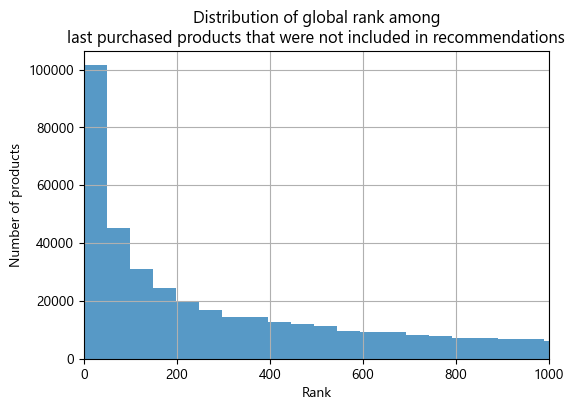

In [247]:
ax = total_missed_last_products['total_rank'].plot(
    kind='hist', bins=1000,
    title='Distribution of global rank among\n'
    'last purchased products that were not included in recommendations',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_xlabel('Rank')
ax.set_ylabel('Number of products')
_ = ax.set_xlim(0, 1000)

In [251]:
bins = [
    pd.Interval(left=left, right=left+50, closed='left') 
    for left in range(int(np.ceil(total_missed_last_products['total_rank'].min())), int(np.ceil(total_missed_last_products['total_rank'].max())), 50)  
]
plot_data = total_missed_last_products['total_rank'].value_counts(bins=bins).reset_index(name='number_of_products')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['total_rank'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)
plot_data

,range,number_of_products,total_rank
0,"[1, 51)",101462,26.0
1,"[51, 101)",45644,76.0
2,"[101, 151)",31639,126.0
3,"[151, 201)",24519,176.0
4,"[201, 251)",19594,226.0
...,...,...,...
984,"[49051, 49101)",4,49076.0
985,"[45301, 45351)",4,45326.0
986,"[47801, 47851)",4,47826.0
987,"[49101, 49151)",3,49126.0


In [252]:
total_missed_last_products['total_rank'].describe()

count    765685.000000
mean       3676.354599
std        6399.451998
min           1.000000
25%         176.000000
50%        1042.000000
75%        4104.000000
max       49412.000000
Name: total_rank, dtype: float64

In [253]:
save_data(plot_data, 'plot_missed_hist_data.dmp')

The histogram shows that products with a high global rating are most often mistakenly not included in the recommendations. Let's try to take this circumstance into account and adjust the model's operation. To do this, we will increase the ratings of popular products (with high global ratings). Let's call this rating adjustment "popularity filtering". As before, we will build it on the basis of exponential filtering. As a result, the product rating will be calculated using the following formula:
$$r^*_{u,i}=r_{u,i} e^{r^g_i a_p},$$
where&nbsp;$r_{u,i}$ is the rating of product number $i$ for customer number $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r^g_i$ is the global rating of product number $i$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$a_p$ - rate of filtering products by popularity.

To check the effect of filtering by popularity and the impact of the value of the rate $a_p$ on the accuracy of predictions, we will plot a graph of the dependence of the value of the metric $MAP@10$ on the value of this rate.

In [198]:
start, stop, num = 0.0, 1.0, 21
map10_total = multiprocessing(start=start, stop=stop, num=num, func='get_map10_by_total_rates', 
                              days_rate=days_rate, cart_rate=cart_rate)


IPython CPU timings (estimated):
  User   :       0.05 s.
  System :       0.00 s.
Wall time:     162.97 s.


<Figure size 640x480 with 0 Axes>

In [201]:
map10_total_approximated, total_rate = f.approximate_precision_by_rate(map10_total.index, map10_total, 3)
total_weights = f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate)
total_ratings = f.get_ratings(total_weights, total_rate=total_rate)
total_prediction = f.get_prediction(total_ratings)
total_map10 = f.get_prediction_precision(last_products, total_prediction)

In [202]:
# Saving data
save_data(total_map10, 'total_map10.dmp')
save_data(total_rate, 'total_rate.dmp')

In [203]:
plot_data = map10_total.reset_index()
plot_data['type'] = 'actual'
index = pd.RangeIndex(map10_total.shape[0], map10_cart.shape[0] + map10_total_approximated.shape[0])
for i in index:
    plot_data.loc[i, 'type'] = 'approximated'
plot_data.loc[index, 'total_rate'] = map10_total.index
plot_data.loc[index, 'precision'] = map10_total_approximated
# plot_data.loc[index.stop] = [days_rate, days_map10, 'peak']
plot_data

,total_rate,precision,type
0,0.00,0.326484,actual
1,0.05,0.326765,actual
2,0.10,0.327030,actual
3,0.15,0.327191,actual
4,0.20,0.327355,actual
5,0.25,0.327426,actual
6,0.30,0.327486,actual
7,0.35,0.327509,actual
8,0.40,0.327469,actual
9,0.45,0.327406,actual


In [204]:
save_data(plot_data, 'plot_total_data.dmp')

In [205]:
bins = [
    pd.Interval(left=left, right=left+1) 
    for left in range(int(np.floor(total_ratings['rating'].min())), int(np.ceil(total_ratings['rating'].max())))  
]
plot_data = total_ratings['rating'].value_counts(bins=bins).reset_index(name='number_of_products')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['rating'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)
plot_data

,range,number_of_products,rating
0,"(0, 1]",7850211,0.5
1,"(1, 2]",804282,1.5
2,"(2, 3]",256302,2.5
3,"(3, 4]",107132,3.5
4,"(4, 5]",52996,4.5
5,"(5, 6]",27612,5.5
6,"(6, 7]",14991,6.5
7,"(7, 8]",7626,7.5
8,"(8, 9]",4137,8.5
9,"(9, 10]",2504,9.5


In [206]:
save_data(plot_data, 'plot_total_hist_data.dmp')

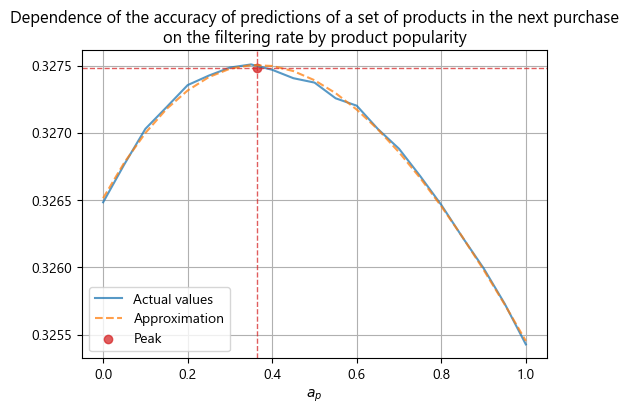

In [217]:
ax = map10_total.plot(
    title='Dependence of the accuracy of predictions of a set of products in the next purchase\n'
    'on the filtering rate by product popularity',
    xlabel='$a_p$',
    figsize=(6, 4), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.plot(map10_total.index.values, map10_total_pred, linestyle='--', color='#ff7f0e', alpha=0.75)
ax.scatter(total_rate, total_map10, color='#d62728', linewidth=1, alpha=0.75)
ax.axvline(total_rate, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
ax.axhline(total_map10, color='#d62728', linestyle='--', linewidth=1, alpha=0.75)
_ = ax.legend(['Actual values', 'Approximation', 'Peak'])

The graph shows that the value of the rate $a_p$ affects the quality of filtration. Thus, when the values of these rates are close to zero (i.e., with weak filtration), as it should be, the value of the $MAP@10$ metric is close to the value obtained by filtering by the time of purchase and the ordinal number of adding the product to the cart. Then, as the rate grows, a slight increase in the quality of filtration is observed, which reaches its **peak** at a rate value in the region of **0.3...0.4**. With continued growth of the rate value, the quality of filtration begins to **rapidly decrease**. And when the rate values **are greater than 0.8**, the influence of filtration becomes **negative** (the $MAP@10$ metric falls below the value obtained by filtering by the time and ordinal number of adding the product to the cart).

Let's try to determine the position and magnitude of the peak of this dependence more precisely. To do this, we approximate the function $MAP@10(a_p)$ on the segment $[0, 1.0]$ using a polynomial function. After that, we find a point on this segment at which the derivative of this function is equal to zero. This will be the point of the approximate position of the peak. And then at that point we find the real value of the metric $MAP@10$.

In [218]:
md(
    '**Results**:<br>'
    'Filtering by product popularity gave a **small increase in accuracy** of predictions '
    f'(the $MAP@10$ metric **increased** by only **{(total_map10 - cart_map10):.6f}** from {cart_map10:.6f} to {total_map10:.6f}) '
    f'with the filtering rate $a_p$ equal to **{total_rate:.6f}**.'
)

**Results**:<br>Filtering by product popularity gave a **small increase in accuracy** of predictions (the $MAP@10$ metric **increased** by only **0.000997** from 0.326484 to 0.327481) with the filtering rate $a_p$ equal to **0.365130**.

#### Filling in missing products

In our model, we rated the customer's products that he had previously purchased. But we need to offer the customer a certain number of products. It is quite possible that he had previously purchased a smaller number of unique products. In this case, it makes sense to offer him products that are in high demand among other customers in addition to the products previously purchased by the customer. It is logical to assume that the customer should be offered products from those groups from which he had previously actively purchased products.

Let's check if our assumption is correct. To do this, we will determine the ranks of product groups for each customer in accordance with the total rating of the products included in this group:

$$r_{u,a}=\sum_{i \in I_a}r_{u,i},$$
where&nbsp;$r_{u,i}$ is the rating of product with number $i$ for customer with number $u$;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$I_a$ are the product numbers in product group with number $a$ ($a \in A$, where $A$ is the set of product group numbers, $I_a \in I$, where $I$ is the set of product numbers).

In each group, we rank products based on their global ratings $r^g_i$.

In [219]:
ratings = f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate))
aisle_ranks = f.get_aisle_ranks(ratings, products)
inside_aisle_ranks = f.get_inside_aisle_ranks(ratings, products)

Then we'll find a list of the latest products purchased by customers that were mistakenly not included in the recommendations.

In [220]:
prediction = f.get_prediction(
    f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate), total_rate=total_rate))
missed_last_products = last_transactions\
    .merge(prediction, on=['user_id', 'product_id'], how='left')
missed_last_products = missed_last_products.loc[missed_last_products['rating'].isna()]\
    .reset_index(drop=True).drop(columns='rating')

Next, let's look at the distribution of these obtained ranks among the most recently purchased products by customers that were not included in the recommendations.

In [221]:
missed_last_products = missed_last_products.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')
missed_last_products = missed_last_products.merge(aisle_ranks, on=['user_id', 'aisle_id'], how='left')
missed_last_products = missed_last_products.merge(inside_aisle_ranks, on=['product_id', 'aisle_id'], how='left')

# Saving data
save_data(missed_last_products, 'missed_last_products.dmp')

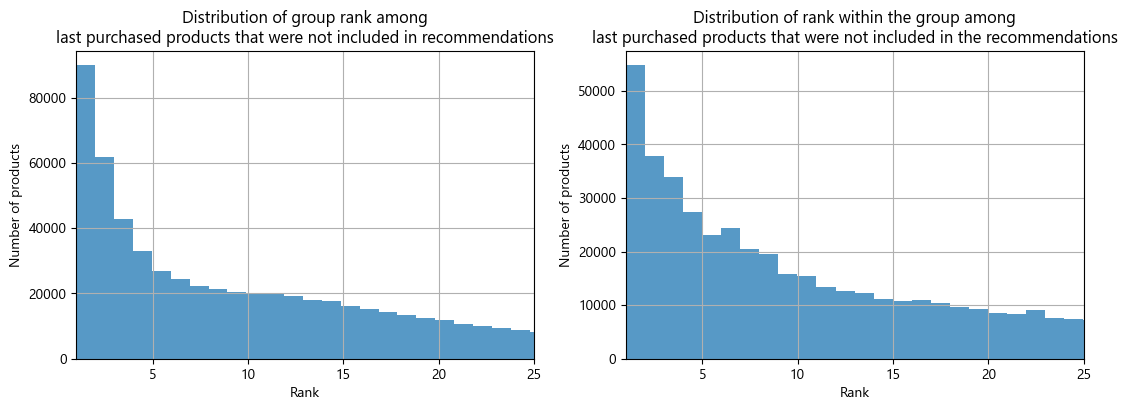

In [222]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
missed_last_products['aisle_rank'].plot(
    ax=ax1, kind='hist', bins=int(missed_last_products['aisle_rank'].max()),
    title='Distribution of group rank among\n'
    'last purchased products that were not included in recommendations',
    grid=True, fontsize=10, legend=False, alpha=0.75)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Number of products')
_ = ax1.set_xlim(1, 25)
missed_last_products['inside_aisle_rank'].plot(
    ax=ax2, kind='hist', bins=int(missed_last_products['inside_aisle_rank'].max()),
    title='Distribution of rank within the group among\n'
    'last purchased products that were not included in the recommendations',
    grid=True, fontsize=10, legend=False, alpha=0.75)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Number of products')
_ = ax2.set_xlim(1, 25)

The histograms show that the assumption has a right to exist, since a significant portion of the products that were mistakenly not included in the recommendations belong to high-ranking groups and have a high rank in their groups.

Let's check what effect this filling has on training data.

In [237]:
bins = [
    pd.Interval(left=left, right=left+1, closed='left') 
    for left in range(int(np.floor(missed_last_products['aisle_rank'].min())), int(np.ceil(missed_last_products['aisle_rank'].max())))  
]
plot_data = missed_last_products['aisle_rank'].value_counts(bins=bins).reset_index(name='number_of_products')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['aisle_rank'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)
plot_data

,range,number_of_products,aisle_rank
0,"[1, 2)",89873,1.5
1,"[2, 3)",61822,2.5
2,"[3, 4)",42902,3.5
3,"[4, 5)",32876,4.5
4,"[5, 6)",27011,5.5
...,...,...,...
95,"[95, 96)",0,95.5
96,"[96, 97)",0,96.5
97,"[97, 98)",0,97.5
98,"[99, 100)",0,99.5


In [238]:
save_data(plot_data, 'plot_aisle_rank_hist_data.dmp')

In [223]:
prediction = f.get_prediction(
    f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate), total_rate=total_rate))
filled_up_prediction = f.fill_up_prediction(prediction, aisle_ranks, inside_aisle_ranks)
filled_up_map10 = f.get_prediction_precision(last_products, filled_up_prediction)

In [239]:
bins = [
    pd.Interval(left=left, right=left+1, closed='left') 
    for left in range(int(np.floor(missed_last_products['inside_aisle_rank'].min())), int(np.ceil(missed_last_products['inside_aisle_rank'].max())))  
]
plot_data = missed_last_products['inside_aisle_rank'].value_counts(bins=bins).reset_index(name='number_of_products')
plot_data.rename(columns={'index': 'range'}, inplace=True)
plot_data['inside_aisle_rank'] = plot_data['range'].map(lambda interval: (interval.left + interval.right) / 2)
plot_data

,range,number_of_products,inside_aisle_rank
0,"[1, 2)",54761,1.5
1,"[2, 3)",37820,2.5
2,"[3, 4)",33927,3.5
3,"[4, 5)",27352,4.5
4,"[6, 7)",24355,6.5
...,...,...,...
1236,"[1112, 1113)",0,1112.5
1237,"[1114, 1115)",0,1114.5
1238,"[1115, 1116)",0,1115.5
1239,"[1118, 1119)",0,1118.5


In [240]:
save_data(plot_data, 'plot_in_aisle_rank_hist_data.dmp')

In [224]:
md(
    '**Results**:<br>'
    'Adding popular products from popular groups to predictions gave a **minor increase in the accuracy** of predictions '
    f'(the $MAP@10$ metric **increased** by only **{(filled_up_map10 - total_map10):.6f}** from {total_map10:.6f} to {filled_up_map10:.6f}).'
)

**Results**:<br>Adding popular products from popular groups to predictions gave a **minor increase in the accuracy** of predictions (the $MAP@10$ metric **increased** by only **0.000005** from 0.327481 to 0.327486).

In [282]:
# Saving data
save_data(filled_up_map10, 'filled_up_map10.dmp')

### Testing the recommendation model

In [255]:
md(
    'We will test the model on the full set of transactions with successive addition of transaction filters, just like during training. '
    'First, we will find the accuracy of predictions using only frequency filtering. Then we will add time filtering. '
    'Then we will additionally apply filtering by the number of adding a product to the cart. '
    'Then we will additionally apply filtering by popularity. And at the last stage we will apply filling. '
    f'We will send the results for verification to the **Kaggle** platform as a solution for the "**{COMPETITION}**" competition.'
)

We will test the model on the full set of transactions with successive addition of transaction filters, just like during training. First, we will find the accuracy of predictions using only frequency filtering. Then we will add time filtering. Then we will additionally apply filtering by the number of adding a product to the cart. Then we will additionally apply filtering by popularity. And at the last stage we will apply filling. We will send the results for verification to the **Kaggle** platform as a solution for the "**skillbox-recommender-system**" competition.

In [256]:
if not EVAL_PATH.exists():
    EVAL_PATH.mkdir()

In [257]:
tests = pd.DataFrame(
    [
        ['Frequency filtering', 1, 0, 0, 0, 0],
        ['Frequency and time filtering', 1, 1, 0, 0, 0],
        ['Frequency, time and product addition number filtering', 1, 1, 1, 0, 0],
        ['Full set of filtering', 1, 1, 1, 1, 0],
        ['Full set of filtering and filling', 1, 1, 1, 1, 1]
    ],
    columns = ['description', 'frequency_filtering', 'days_filtering', 'cart_filtering', 'popularity_filtering', 'filling_up']
)
tests['file_name'] = tests[['frequency_filtering', 'days_filtering', 'cart_filtering', 'popularity_filtering', 'filling_up']]\
     .apply(lambda params: '_'.join([column for param, column in zip(params, params.index) if param]) + '.csv', axis=1)

In [258]:
transactions = prior_transactions.copy()
transactions['days_before_last_order'] += transactions['days_before_last_order_shift']
transactions = pd.concat([transactions, last_transactions])
for _, (
    days_filtering, cart_filtering, popularity_filtering, filling_up, file_name
) in tests[['days_filtering', 'cart_filtering', 'popularity_filtering', 'filling_up', 'file_name']].iterrows():
    prediction = f.get_prediction(
        f.get_ratings(
            f.get_weights(
                transactions, 
                days_rate=days_rate if days_filtering else 0., 
                cart_rate=cart_rate if cart_filtering else 0.
            ), 
            total_rate=total_rate if popularity_filtering else 0.
        ), 
    )
    if filling_up:
        ratings = f.get_ratings(f.get_weights(prior_transactions, days_rate=days_rate, cart_rate=cart_rate))
        aisle_ranks = f.get_aisle_ranks(ratings, products)
        inside_aisle_ranks = f.get_inside_aisle_ranks(ratings, products)
        prediction = f.fill_up_prediction(prediction, aisle_ranks, inside_aisle_ranks)
    f.save_kaggle_submission_csv(
        prediction,
        EVAL_PATH / file_name
    )

In [259]:
kaggle.send_submission_files(EVAL_PATH.as_posix() + '/' + tests['file_name'], tests['description'])
test_results = kaggle.receive_submission_scores(tests['description'])
test_results['meanScore'] = test_results[['publicScore', 'privateScore']].mean(axis=1)
test_results['rank'] = test_results['meanScore'].rank().astype(int)

1/5: Sending file "D:/skillbox-recommender-system/eval/frequency_filtering.csv" of submission "Frequency filtering" to competition "skillbox-recommender-system"...
1/5: Successfully submitted.
2/5: Sending file "D:/skillbox-recommender-system/eval/frequency_filtering_days_filtering.csv" of submission "Frequency and time filtering" to competition "skillbox-recommender-system"...
2/5: Successfully submitted.
3/5: Sending file "D:/skillbox-recommender-system/eval/frequency_filtering_days_filtering_cart_filtering.csv" of submission "Frequency, time and product addition number filtering" to competition "skillbox-recommender-system"...
3/5: Successfully submitted.
4/5: Sending file "D:/skillbox-recommender-system/eval/frequency_filtering_days_filtering_cart_filtering_popularity_filtering.csv" of submission "Full set of filtering" to competition "skillbox-recommender-system"...
4/5: Successfully submitted.
5/5: Sending file "D:/skillbox-recommender-system/eval/frequency_filtering_days_filteri

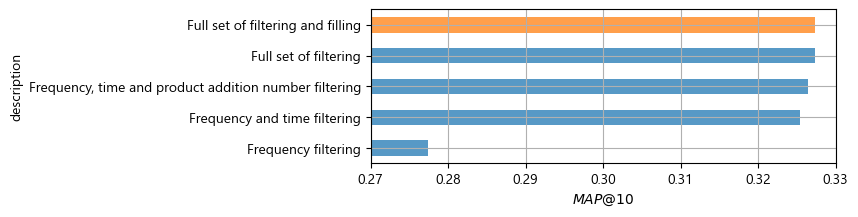

In [260]:
test_results['color'] = '#1f77b4'
test_results.at[test_results['meanScore'].idxmax(), 'color'] = '#ff7f0e'
ax = test_results.plot(
    kind='barh', x='description', y='meanScore', color=test_results['color'], 
    title={}, xlabel='',
    figsize=(6, 2), grid=True, fontsize=10, legend=False, alpha=0.75)
ax.set_xlabel('$MAP@10$')
_ = ax.set_xlim(0.27, 0.33)

In [261]:
test_results.set_index('description')[['publicScore', 'privateScore', 'meanScore']].style.highlight_max(color='#FF9F4A')

,publicScore,privateScore,meanScore
description,,,
Frequency filtering,0.278240,0.276620,0.277430
Frequency and time filtering,0.326430,0.324390,0.325410
"Frequency, time and product addition number filtering",0.327320,0.325430,0.326375
Full set of filtering,0.328210,0.326390,0.327300
Full set of filtering and filling,0.328220,0.326400,0.327310


In [262]:
save_data(test_results, 'test_results.dmp')

In [263]:
best_map10 = test_results['meanScore'].max()
best_params = test_results.at[test_results['meanScore'].idxmax(), 'description']

In [264]:
md(
    '**Conclusions:**<br>'
    '1. Simple filtering by purchase frequency already provides the required prediction accuracy '
    f'(${test_results.at[0, "meanScore"]:.6f} > 0.20954$). '
    f'Other types of filtering significantly improve the result (up to ${test_results.at[4, "meanScore"]:.6f}$). '
    f'The main increase in accuracy was provided by filtering by purchase time ($+{(test_results.at[1, "meanScore"] - test_results.at[0, "meanScore"]):.6f}$). '
    f'We also added a little filtering by the number of the product added to the cart and its popularity '
    f'($+{(test_results.at[2, "meanScore"] - test_results.at[1, "meanScore"]):.6f}$ and '
    f'$+{(test_results.at[3, "meanScore"] - test_results.at[2, "meanScore"]):.6f}$ respectively). '
    f'But filling made an insignificant contribution '
    f'$+{(test_results.at[4, "meanScore"] - test_results.at[3, "meanScore"]):.6f}$).<br>'
    f'2. The accuracy of the model\'s predictions on test data (${test_results.at[4, "meanScore"]:.6f}$) '
    f'is comparable to the accuracy shown during validation on training data (${filled_up_map10:.6f}$). '
    'This means that the **algorithm** of the model is **quite functional**, and the **model itself is well trained**.'
)

**Conclusions:**<br>1. Simple filtering by purchase frequency already provides the required prediction accuracy ($0.277430 > 0.25$). Other types of filtering significantly improve the result (up to $0.327310$). The main increase in accuracy was provided by filtering by purchase time ($+0.047980$). We also added a little filtering by the number of the product added to the cart and its popularity ($+0.000965$ and $+0.000925$ respectively). But filling made an insignificant contribution $+0.000010$).<br>2. The accuracy of the model's predictions on test data ($0.327310$) is comparable to the accuracy shown during validation on training data ($0.327486$). This means that the **algorithm** of the model is **quite functional**, and the **model itself is well trained**.